### Neste notebook, utilizaremos a biblioteca YFinance para testar um modelo Arima de previsão de preços de ações. Faremos os testes de estacionaridade e transformações necessárias. Será utilizado o plot ACF e PACF para decidir o número de lags utilizados para os componentes AR e MA do modelo ARIMA, respectivamente. Este notebook possui intenção apenas de estudo e não deve ser levado em consideração para decisões de investimento.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import yfinance as yf
import pandas_datareader as pdr

### Estudaremos a série de fechamento ajustado de ITUB3

In [3]:
ticker = 'ITUB3.SA'
dt_inicial = '2021-01-01'
dt_final = '2024-05-15'

fechamento = yf.download(ticker, start=dt_inicial, end=dt_final)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


### Primeiramente, vamos visualizar como a série se parece em sua totalidade.

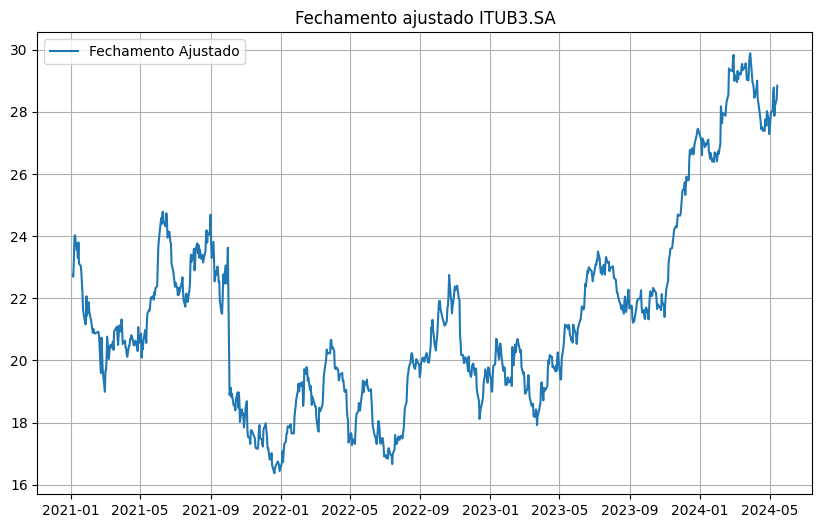

In [4]:
plt.figure(figsize=(10, 6))
plt.title(f'Fechamento ajustado {ticker}')
plt.plot(fechamento, label='Fechamento Ajustado')
plt.legend()
plt.grid(True)
plt.show()


### Utilizaremos o teste ADF para checar se a série é estacionária.

In [216]:
from statsmodels.tsa.stattools import adfuller

def adf_check(serie):

    result = adfuller(serie)
    print("Augmented Dickey-Fuller Test:")
    labels = ['ADF Statistic', 'p-valor', '#Lags', 'N de Observações']

    for i, j in zip(result, labels):
        print(f"{j:25} = {i}")

    if result[1] <= 0.05:
        print("Conclusão: A série temporal porvavelmente é estacionária.")
    else:
        print("Conclusão: A série temporal porvavelmente não é estacionária.")

adf_check(fechamento)

Augmented Dickey-Fuller Test:
ADF Statistic             = -0.6164518825902796
p-valor                   = 0.8672210745435658
#Lags                     = 1
N de Observações          = 835
Conclusão: A série temporal porvavelmente não é estacionária.


In [7]:
df_fechamento = pd.DataFrame(data=fechamento, index=fechamento.index)
serie_fechamento = df_fechamento['Adj Close']

### O teste aponta que a série provavelmente não é estacionária. Antes de decidir como tratar a série, faremos a decomposição da série tanto pelo método aditivo quanto multiplicativo.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposicao_add = seasonal_decompose(serie_fechamento, model='additive', period=1)
decomposicao_mult = seasonal_decompose(serie_fechamento, model='multiplicative', period=1)


In [10]:
trend_add = decomposicao_add.trend
sazonal_add = decomposicao_add.seasonal
residuo_add = decomposicao_add.resid
trend_mult = decomposicao_mult.trend
sazonal_mult = decomposicao_mult.seasonal
residuo_mult = decomposicao_mult.resid

### Decomposição Aditiva

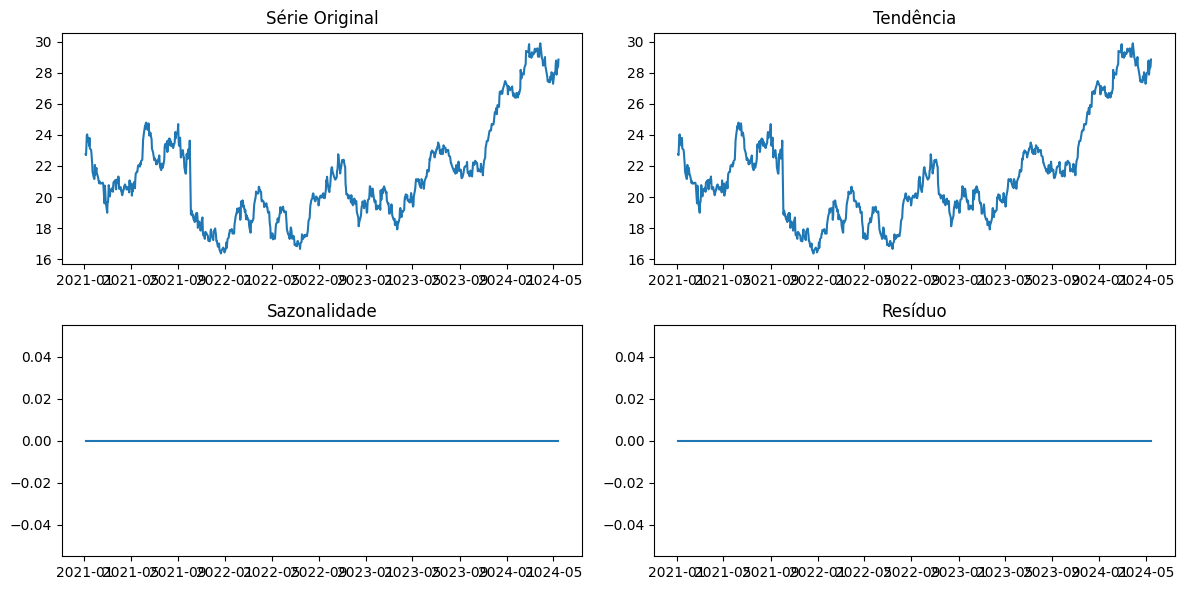

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(df_fechamento.index, df_fechamento['Adj Close'], label='Série Original')
plt.title('Série Original')

plt.subplot(2, 2, 2)
plt.plot(df_fechamento.index, trend_add)
plt.title('Tendência')

plt.subplot(2, 2, 3)
plt.plot(df_fechamento.index, sazonal_add)
plt.title('Sazonalidade')

plt.subplot(2, 2, 4)
plt.plot(df_fechamento.index, residuo_add)
plt.title('Resíduo')

plt.tight_layout()
plt.show()

### Decomposição Multiplicativa

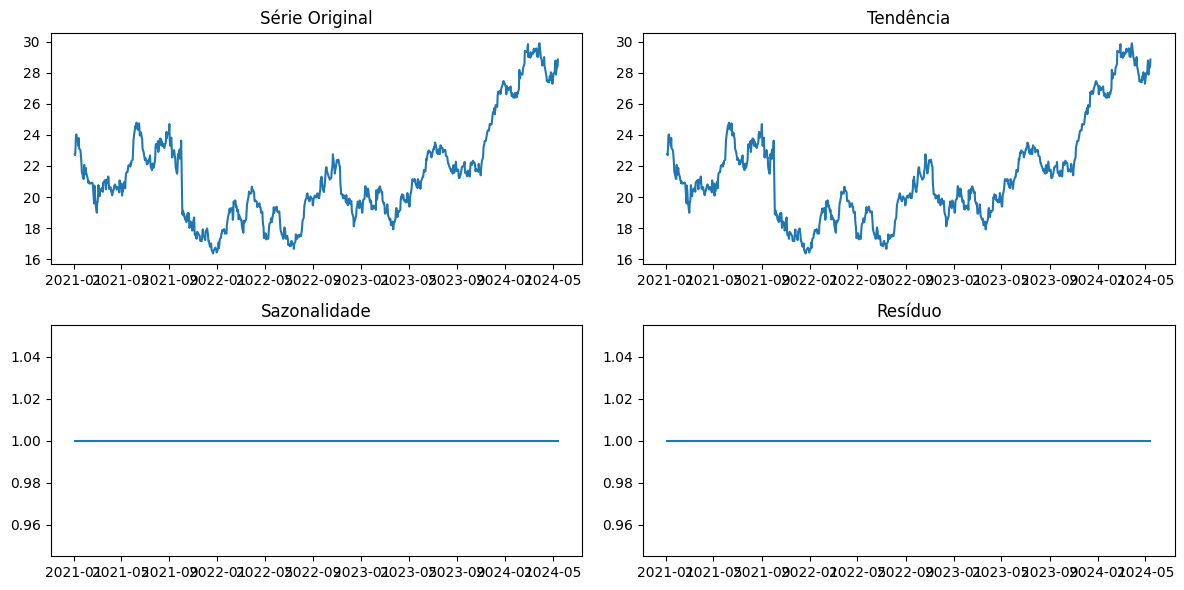

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(df_fechamento.index, df_fechamento['Adj Close'], label='Série Original')
plt.title('Série Original')

plt.subplot(2, 2, 2)
plt.plot(df_fechamento.index, trend_mult)
plt.title('Tendência')

plt.subplot(2, 2, 3)
plt.plot(df_fechamento.index, sazonal_mult)
plt.title('Sazonalidade')

plt.subplot(2, 2, 4)
plt.plot(df_fechamento.index, residuo_mult)
plt.title('Resíduo')

plt.tight_layout()
plt.show()

### Na decomposição, encontramos apenas o componente de tendência. Vamos dividir o dataset em treino e teste. Depois disso, definiremos a função que irá diferenciar a série de maneira a torná-la estacionária e também a função que retornará os valores na escala original após as previsões. Utilizaremos a diferenciação de nível 1, subtraindo cada valor de seu anterior para lidar com o componente de tendência.

In [207]:
tamanho = int(len(df_fechamento) - 60)
treino, teste = df_fechamento[0:tamanho], df_fechamento[tamanho:]

historico = [treino for x in treino]
previsoes = []

In [47]:
def diferenciar(df, intervalo=1):
  diff= []
  for i in range(intervalo, len(df) - 1):
    valor = df[i] - df[i - intervalo]
    diff.append(valor)
  return diff

def diferenciar_inverso(historico, previsoes, intervalo=1):
  return previsao + historico[-intervalo]

### Iremos prever 60 dias, portanto, dividiremos o dataset de teste com os preços dos 60 dias finais da série filtrada inicialmente.

In [129]:
serie_treino = pd.Series(treino['Adj Close'])
serie_teste = pd.Series(teste['Adj Close'])

In [130]:
treino_diff = diferenciar(serie_treino)

### Agora, iremos fazer a plotagem dos testes ACF e PACF para definir o número de lags para os componentes AR e MA.

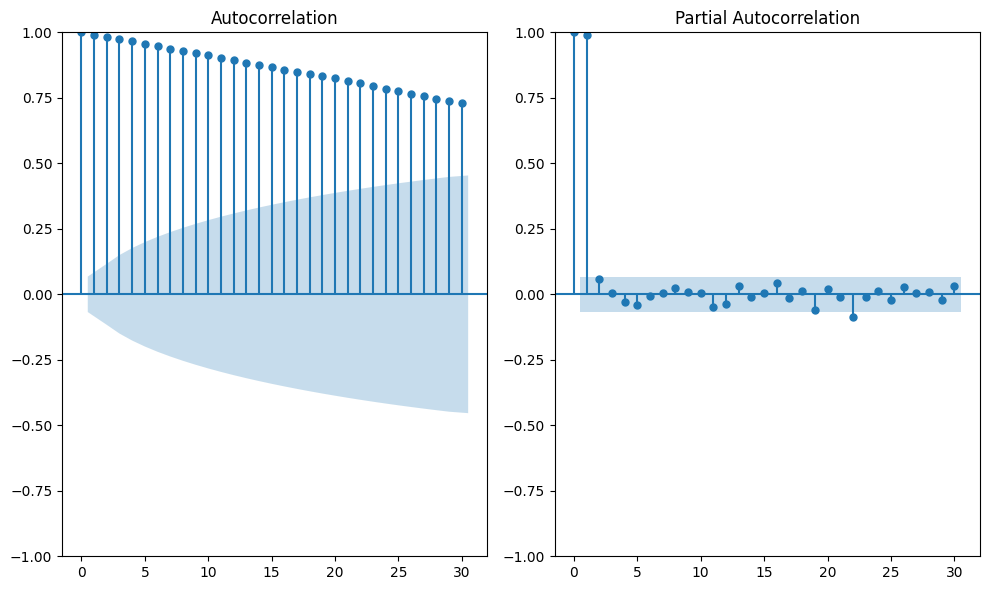

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
plot_acf(df_fechamento['Adj Close'], ax=ax[0])
plot_pacf(df_fechamento['Adj Close'], ax=ax[1])

plt.tight_layout()
plt.show()


### Para interpretar estes testes, devemos verificar se os picos ultrapassam a zona sombreada em azul. Caso estejam fora dela, interpretamos que o nível de significância foi ultrapassado e, portanto, o pico deve ser levado em conta na contagem porque há autocorrelação entre os valores. De acordo com o teste ACF, os lags da a série parecem ser altamente correlacionados. Iremos testar AR = 1 já que faremos a previsão dos preços diários no nosso teste. Para o componente MA, utilizaremos 2. o termo I será 0 porque a série já foi diferenciada anteriormente.

In [208]:
from statsmodels.tsa.arima.model import ARIMA

for x in range (len(teste)):
  model = ARIMA(treino_diff, order=(1, 0, 2))
  model_fit = model.fit()
  previsao = model_fit.forecast()[0]
  previsao_real = diferenciar_inverso(historico, previsao, intervalo=1)
  previsoes.append(previsao_real)
  valor_real = serie_teste[x]
  historico.append(valor_real)

In [213]:
df_teste = pd.DataFrame(data=serie_teste)
df_previsoes = pd.DataFrame(data=previsoes[1:], index=df_teste[1:].index)

### Após um pequeno tratamento do teste e das previsões, faremos o plot dos valores previstos e dos valores originais.

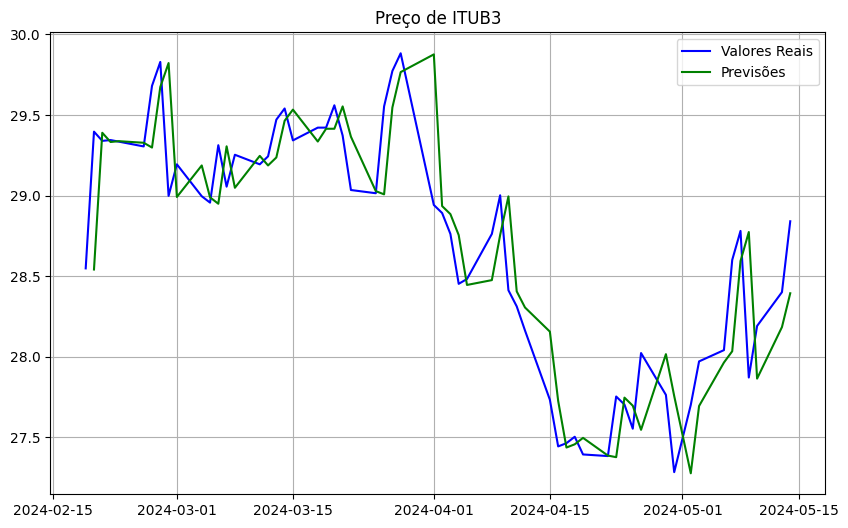

In [217]:
plt.figure(figsize=(10, 6))

# Plot da série_teste
plt.plot(df_teste, label='Valores Reais', color='blue')

# Plot das previsões
plt.plot(df_previsoes, label='Previsões', color='green')

# Adicione legendas e título
plt.legend()
plt.title('Preço de ITUB3')

# Mostre o plot
plt.grid(True)
plt.show()

### Como podemos observar, o nosso modelo teve um bom fit nos preços reais e capturou bem os movimentos da ação ao longo do tempo. É evidente que isso não garante que o modelo funcionaria bem para garantir lucros reais. É importante ressaltar também que os preços simplesmente tendem a ser próximos de seu fechamento anterior, o que pode ter ajudado no funcionamento do modelo que, graficamente, parece se ajustar bem após mudanças mais bruscas. Porém, na vida real, o desafio nem sempre será tão simples o que motiva a construção de novos estudos para previsões com outros intervalos de tempo, por exemplo.

### A conclusão deste estudo é positiva, mostra que é possível utilizar técnicas estatísticas e ciência de dados para entender os movimentos do mercado e inspira a utilização de outras técnicas em estudos futuros para previsão, como algoritmos de Machine Learning (principalmente bagging e boosting) e a utilização de redes neurais, como LSTM, GRU ou mesmo Redes Neurais Convolucionais.